In [35]:
import xarray as xr
import rasterio as rio
import rioxarray
from glob import glob
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [24]:
# functions to load interferogram tifs to xarray
def xr_read_geotif(geotif_file_path, masked=True):
    da = rioxarray.open_rasterio(geotif_file_path, masked=True)

    # Extract bands and assign as variables in xr.Dataset()
    ds = xr.Dataset()
    for i, v in enumerate(da.band):
        da_tmp = da.sel(band=v)
        da_tmp.name = "band" + str(i + 1)

        ds[da_tmp.name] = da_tmp

    # Delete empty band coordinates.
    del ds.coords["band"]

    return ds

def combine_ds(data_dir, file_type='horizontal_velocity'):
    datasets = []

    tif_list = glob(f'{data_dir}/S2*{file_type}.tif')
    for tif_path in tif_list:
        dates = tif_list[0].split('/')[-1][3:20] #parse filename for dates
        start_date = datetime.strptime(dates[:8], '%Y%m%d')
        end_date = datetime.strptime(dates[-8:], '%Y%m%d')
        t_baseline = end_date - start_date
        
        src = xr_read_geotif(tif_path, masked=False) #read product to xarray ds
        src = src.assign_coords({"dates": dates})
        src = src.expand_dims("dates")
        
        src = src.assign_coords(start_date = ('dates', [start_date]))
        src = src.assign_coords(end_date = ('dates', [end_date]))
        src = src.assign_coords(t_baseline = ('dates', [t_baseline]))

        src = src.rename({'band1':file_type})
        
        datasets.append(src)
       
    ds = xr.concat(datasets, dim="dates", combine_attrs="no_conflicts") #create dataset
    ds = ds.sortby('dates')

    return ds 

In [25]:
# read in tifs
veloc_ds = combine_ds('.', 'horizontal_velocity')

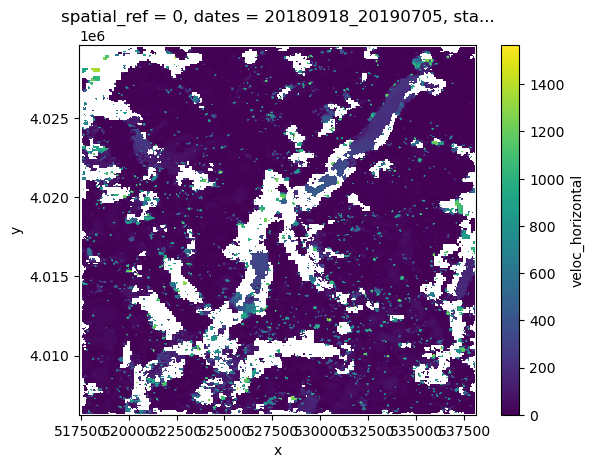

In [29]:
# calculate and save median velocity
veloc_ds.isel(dates=0).horizontal_velocity.plot()

In [34]:
# calculate and save median velocity
veloc_da_median = veloc_ds.horizontal_velocity.median(dim='dates')
# save standard deviation of velocity
veloc_da_stdev = veloc_ds.horizontal_velocity.std(dim='dates')
# save valid velocity pixel count
veloc_da_count = veloc_ds.horizontal_velocity.count(dim='dates')

/srv/conda/envs/image-correlation/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


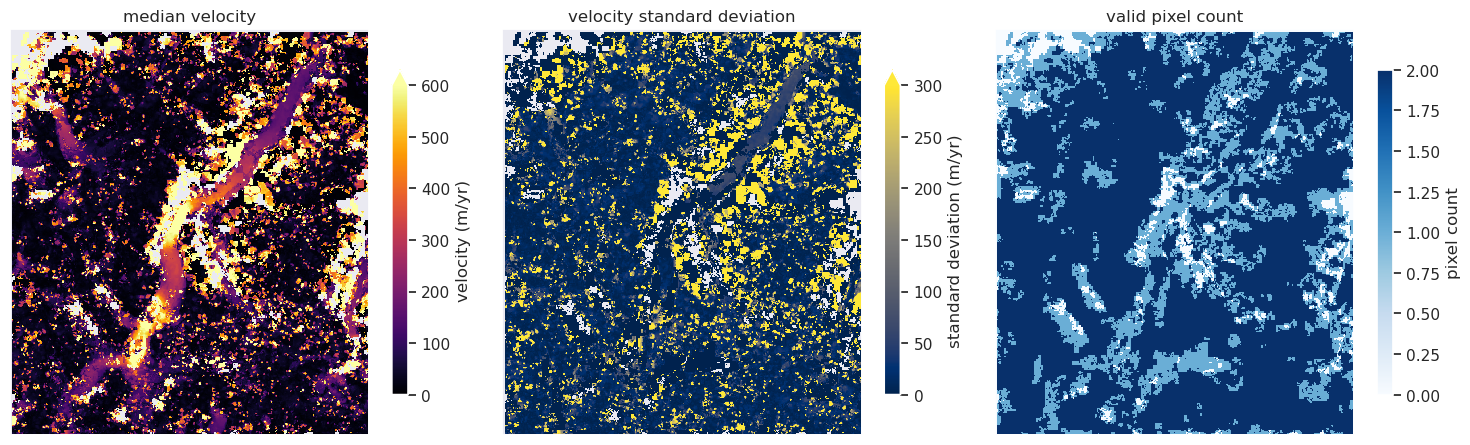

In [38]:
sns.set_theme()
f, ax = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
veloc_da_median.plot(ax=ax[0], vmin=0, vmax=600, cmap='inferno', cbar_kwargs= {'shrink':0.7, 'label':'velocity (m/yr)'})
veloc_da_stdev.plot(ax=ax[1], vmin=0, vmax=300, cmap='cividis', cbar_kwargs= {'shrink':0.7, 'label':'standard deviation (m/yr)'})
veloc_da_count.plot(ax=ax[2], vmin=0, cmap='Blues', cbar_kwargs= {'shrink':0.7, 'label':'pixel count'})
ax[0].set_aspect('equal')
ax[1].set_aspect('equal')
ax[2].set_aspect('equal')
ax[0].set_title(f'median velocity')
ax[1].set_title(f'velocity standard deviation')
ax[2].set_title(f'valid pixel count')
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[2].set_xticks([])
ax[2].set_yticks([])
ax[0].set_xlabel('')
ax[0].set_ylabel('')
ax[1].set_xlabel('')
ax[1].set_ylabel('')
ax[2].set_xlabel('')
ax[2].set_ylabel('')
f.tight_layout()

f.savefig('velocity_summary_statistics.png', dpi=300)